# Config

In [1]:
WB_CONFIG = {
    "epochs": 10,
    "batch_size": 16,
    "encoder_weights": "imagenet",
    "split_ratio": (0.8, 0.1, 0.1),
    "image_size": (512, 512),
    "learning_rate": 0.0001,
}
INTERNAL_CONFIG = WB_CONFIG.copy()
BUFFER_SIZE = 512

# Dataset initialization

## Helpers

In [3]:
import os
import tensorflow as tf
import random

def make_config(ds_size: int, split_ratio: tuple, batch_size: float) -> dict:
    assert sum(split_ratio) == 1
    train_size = int(ds_size * split_ratio[0])
    val_size = round(ds_size * split_ratio[1])
    test_size = round(ds_size * split_ratio[2])
    return {
        "train_size": train_size,
        "val_size": val_size,
        "test_size": test_size,
        "steps_per_epoch": train_size // batch_size,
        "val_steps": val_size // batch_size
    }

def load_image_paths(data_path: str):
    # Load tumor image paths with their labels
    tumors_data_path = data_path + "/tumors/images/"
    image_paths = [tumors_data_path + im_path for im_path in os.listdir(tumors_data_path)]
    labels = [0 if "empty" in im_path else 1 for im_path in image_paths]
   
    # Load nerve image paths with 0 labels (do not contain tumor)
    nerves_data_path = data_path + "/nerves/images/"
    nerve_image_paths = [nerves_data_path + im_path for im_path in os.listdir(nerves_data_path)]
    image_paths = nerve_image_paths + image_paths
    labels = [0 for _ in nerve_image_paths] + labels
    
    # Load PNI image paths with 1 labels (contain tumor)
    pni_data_path = data_path + "/pni/images/"
    pni_image_paths = [pni_data_path + im_path for im_path in os.listdir(pni_data_path)]
    image_paths = pni_image_paths  + image_paths
    labels = [1 for _ in pni_image_paths] + labels

    # Convert arrays to tensors
    image_paths = tf.convert_to_tensor(image_paths, dtype=tf.string)
    labels = tf.convert_to_tensor(labels, dtype=tf.float32)
    
    return image_paths, labels


# Returns the function that loads a single image and its corresponding label from the provided paths
def load_images(image_size: tuple=(512,512)):
    def load_images_func(image_path, label):
        image = tf.io.read_file(image_path)
        image = tf.io.decode_jpeg(image, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, image_size)
        return image, label

    return load_images_func


# Splits the dataset into 2 parts based on the train_ratio and returns these 2 parts
def split(dataset, train_size: int):
    dataset = dataset.shuffle(buffer_size=BUFFER_SIZE)
    return dataset.take(train_size), dataset.skip(train_size)

## Load dataset

TRAIN: 4275
VAL: 534
TEST: 535


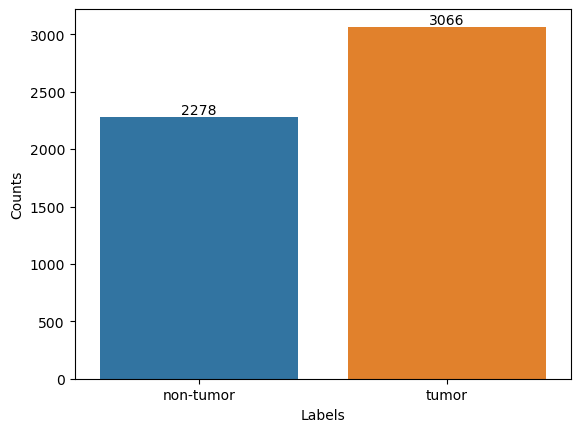

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

DATA_PATH = "/kaggle/input/masters-thesis-extended/data/pancreas"

image_paths, labels = load_image_paths(DATA_PATH)

dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
dataset = dataset.map(load_images(INTERNAL_CONFIG["image_size"]))
ds_size = dataset.cardinality().numpy()

INTERNAL_CONFIG.update(make_config(ds_size, INTERNAL_CONFIG["split_ratio"], INTERNAL_CONFIG["batch_size"]))

train_ds, val_ds = split(dataset, INTERNAL_CONFIG["train_size"])
val_ds, test_ds = split(val_ds, INTERNAL_CONFIG["val_size"])

train_batches = (train_ds.shuffle(BUFFER_SIZE)
                         .batch(INTERNAL_CONFIG["batch_size"])
                         .repeat()
                         .prefetch(buffer_size=tf.data.AUTOTUNE))
val_batches = val_ds.batch(INTERNAL_CONFIG["batch_size"])
test_batches = test_ds.batch(INTERNAL_CONFIG["batch_size"])

# Display cardinality
labels, counts = np.unique(np.fromiter(dataset.map(lambda x, y: y), np.int32), return_counts=True)
labels = ["non-tumor" if l == 0 else "tumor" for l in labels]
plt.ylabel('Counts')
plt.xlabel('Labels')
ax = sns.barplot(x=labels, y=counts)
ax.bar_label(ax.containers[0])

print(f"TRAIN: {train_ds.cardinality()}\nVAL: {val_ds.cardinality()}\nTEST: {test_ds.cardinality()}")

# Tumor classification model

## Prepare model

In [5]:
# Prepare base model for feature extraction 
model = tf.keras.applications.ResNet50V2(input_shape=(*INTERNAL_CONFIG["image_size"], 3), include_top=False, weights=INTERNAL_CONFIG["encoder_weights"])
model.trainable = INTERNAL_CONFIG["encoder_weights"] is None

# Add fully connected layers for classification
x = model.output
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.models.Model(inputs=model.input, outputs=predictions)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(INTERNAL_CONFIG["learning_rate"]), metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

94668760/94668760 [==============================] - 4s 0us/step


## Display architecture

In [6]:
!pip install -q git+https://github.com/paulgavrikov/visualkeras
import visualkeras
from PIL import ImageFont

color_map = {
    tf.keras.layers.InputLayer: {"fill": "gray"},
    tf.keras.layers.ZeroPadding2D: {"fill": "#06d6a0"},
    tf.keras.layers.Conv2D: {"fill": "#ffd166"},
    tf.keras.layers.MaxPooling2D: {"fill": "#de7b1f"},
    tf.keras.layers.BatchNormalization: {"fill": "#118ab2"},
    tf.keras.layers.Add: {"fill": "#ef476f"},
    tf.keras.layers.Dense: {"fill": "#40a62b"},
    tf.keras.layers.GlobalAveragePooling2D: {"fill": "#073b4c"},
}

font=ImageFont.truetype("DejaVuSansMono.ttf", 120)
visualkeras.layered_view(model, legend=True, font=font, color_map=color_map, type_ignore=[tf.keras.layers.Activation], scale_xy=12, max_xy=4000, min_xy=40)

# Training

In [7]:
import wandb
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

wandb.login(key=user_secrets.get_secret("wandb-api-key"))
wandb.init(project="tumor-detection", entity="xjackor", config=WB_CONFIG)

model.fit(train_batches,
          epochs=INTERNAL_CONFIG["epochs"],
          steps_per_epoch=INTERNAL_CONFIG["steps_per_epoch"],
          validation_steps=INTERNAL_CONFIG["val_steps"],
          validation_data=val_batches,
          callbacks=[wandb.keras.WandbCallback()])

wandb.run.finish()

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: xjackor. Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
267/267 [==============================] - ETA: 0s - loss: 0.2960 - binary_accuracy: 0.8851 - recall: 0.9026 - precision: 0.9008

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240514_162343-aq3xfs6y/files/model-best)... Done. 0.5s


267/267 [==============================] - 117s 377ms/step - loss: 0.2960 - binary_accuracy: 0.8851 - recall: 0.9026 - precision: 0.9008 - val_loss: 0.2701 - val_binary_accuracy: 0.9072 - val_recall: 0.8931 - val_precision: 0.9350
Epoch 2/10
267/267 [==============================] - ETA: 0s - loss: 0.2133 - binary_accuracy: 0.9223 - recall: 0.9224 - precision: 0.9439

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240514_162343-aq3xfs6y/files/model-best)... Done. 0.6s


267/267 [==============================] - 99s 372ms/step - loss: 0.2133 - binary_accuracy: 0.9223 - recall: 0.9224 - precision: 0.9439 - val_loss: 0.2226 - val_binary_accuracy: 0.9280 - val_recall: 0.9129 - val_precision: 0.9527
Epoch 3/10
267/267 [==============================] - 77s 289ms/step - loss: 0.1819 - binary_accuracy: 0.9366 - recall: 0.9376 - precision: 0.9536 - val_loss: 0.2323 - val_binary_accuracy: 0.9129 - val_recall: 0.8914 - val_precision: 0.9333
Epoch 4/10
267/267 [==============================] - ETA: 0s - loss: 0.1692 - binary_accuracy: 0.9382 - recall: 0.9404 - precision: 0.9531

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240514_162343-aq3xfs6y/files/model-best)... Done. 0.5s


267/267 [==============================] - 99s 373ms/step - loss: 0.1692 - binary_accuracy: 0.9382 - recall: 0.9404 - precision: 0.9531 - val_loss: 0.1951 - val_binary_accuracy: 0.9299 - val_recall: 0.9388 - val_precision: 0.9288
Epoch 5/10
267/267 [==============================] - ETA: 0s - loss: 0.1551 - binary_accuracy: 0.9415 - recall: 0.9424 - precision: 0.9567

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240514_162343-aq3xfs6y/files/model-best)... Done. 0.5s


267/267 [==============================] - 100s 375ms/step - loss: 0.1551 - binary_accuracy: 0.9415 - recall: 0.9424 - precision: 0.9567 - val_loss: 0.1814 - val_binary_accuracy: 0.9394 - val_recall: 0.9148 - val_precision: 0.9648
Epoch 6/10
267/267 [==============================] - ETA: 0s - loss: 0.1435 - binary_accuracy: 0.9483 - recall: 0.9509 - precision: 0.9602

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240514_162343-aq3xfs6y/files/model-best)... Done. 0.5s


267/267 [==============================] - 101s 379ms/step - loss: 0.1435 - binary_accuracy: 0.9483 - recall: 0.9509 - precision: 0.9602 - val_loss: 0.1791 - val_binary_accuracy: 0.9280 - val_recall: 0.9108 - val_precision: 0.9459
Epoch 7/10
267/267 [==============================] - ETA: 0s - loss: 0.1321 - binary_accuracy: 0.9519 - recall: 0.9521 - precision: 0.9649

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240514_162343-aq3xfs6y/files/model-best)... Done. 0.5s


267/267 [==============================] - 101s 379ms/step - loss: 0.1321 - binary_accuracy: 0.9519 - recall: 0.9521 - precision: 0.9649 - val_loss: 0.1464 - val_binary_accuracy: 0.9527 - val_recall: 0.9542 - val_precision: 0.9576
Epoch 8/10
267/267 [==============================] - 78s 292ms/step - loss: 0.1325 - binary_accuracy: 0.9537 - recall: 0.9525 - precision: 0.9684 - val_loss: 0.1899 - val_binary_accuracy: 0.9337 - val_recall: 0.9275 - val_precision: 0.9446
Epoch 9/10
267/267 [==============================] - 77s 289ms/step - loss: 0.1228 - binary_accuracy: 0.9577 - recall: 0.9601 - precision: 0.9678 - val_loss: 0.1776 - val_binary_accuracy: 0.9337 - val_recall: 0.9382 - val_precision: 0.9348
Epoch 10/10
267/267 [==============================] - 76s 287ms/step - loss: 0.1167 - binary_accuracy: 0.9587 - recall: 0.9588 - precision: 0.9698 - val_loss: 0.1941 - val_binary_accuracy: 0.9337 - val_recall: 0.9288 - val_precision: 0.9394


binary_accuracy,▁▅▆▆▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▂▁▁
precision,▁▅▆▆▇▇████
recall,▁▃▅▆▆▇▇▇██
val_binary_accuracy,▁▄▂▅▆▄█▅▅▅
val_loss,█▅▆▄▃▃▁▃▃▄
val_precision,▂▆▂▁█▄▇▄▂▃
val_recall,▁▃▁▆▄▃█▅▆▅
best_epoch,6
best_val_loss,0.14636


# Evaluation

In [8]:
model.evaluate(test_batches)

34/34 [==============================] - 36s 139ms/step - loss: 0.1564 - binary_accuracy: 0.9439 - recall: 0.9339 - precision: 0.9486


[0.15644106268882751,
 0.9439252614974976,
 0.9338521361351013,
 0.948616623878479]

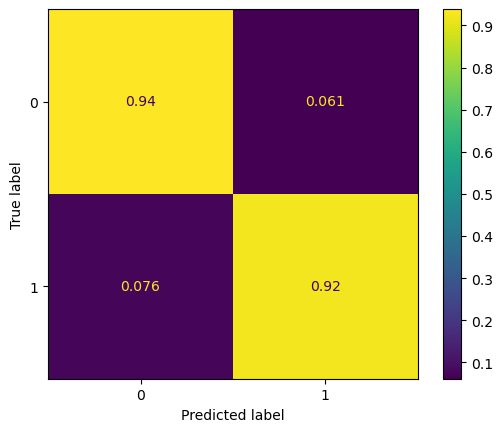

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels, labels_pred = [], []
for image, label in test_batches.unbatch():
    labels_pred.append(model.predict(tf.expand_dims(image, axis=0), verbose=0)[0][0])
    labels.append(label.numpy())


cm = confusion_matrix(labels, np.round(labels_pred), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
